In [1]:
import os
import sys
import pandas as pd

In [2]:
# setting src package as a package
src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)

In [3]:
from d01_data.cab_data import _get_cab_data, aggregate_cab_data, extract_cab_files
from d02_intermediate.cab_data import format_data, prepare_data, _label_velocity_outliers
from d07_visualization.graphs import mobility_map, feature_relations, feature_over_time

#### Extract cab data

In [4]:
# extract cab data
tar_folder = '../data/01_raw'
tar_file = 'cabspottingdata.tar.gz'
extract_cab_files(tar_folder, tar_file)

#### Evaluate a single cab

In [5]:
# get cab data
cab_file_path = '../data/01_raw/cabspottingdata/new_abboip.txt'
cab_data = _get_cab_data(cab_file_path)
formated_cab_data = format_data(cab_data)

2021-01-24 19:50:17,095 - INFO - wrapper - _convert_unix_epoch_to_date took 0:00:00.001964 shape=(23495, 5) null_values=0)
2021-01-24 19:50:17,105 - INFO - wrapper - _sort_data took 0:00:00.007458 shape=(23495, 5) null_values=0)


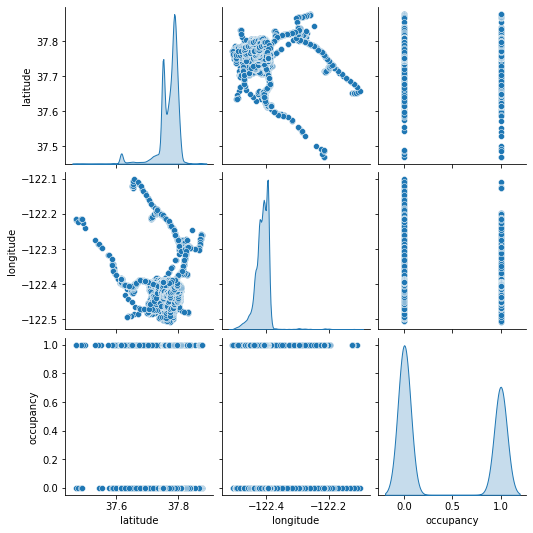

In [6]:
# features relationships
# I can clearly see the san francisco area
# latitude and longitude don't seem to have outliers for this specific cab
# most unoccupied roaming seems to be in the downtown/airport area of san francisco
feature_relations(formated_cab_data)

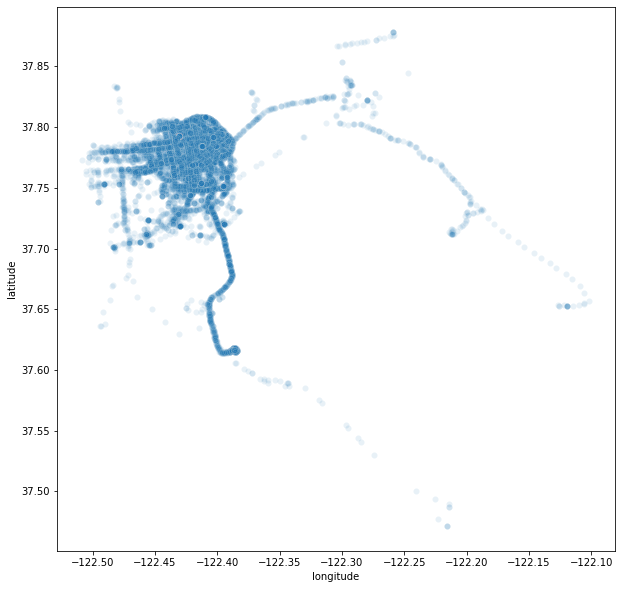

In [7]:
# position visualization
# most of the movement is at San Fancisco downtown and in the street going to the airport
mobility_map(cab_data)

#### Aggregate all the cab data

In [4]:
# aggregates all the cabs data
cabs_data_folder = '../data/01_raw/cabspottingdata'
file_extension = '.txt'
cab_data = aggregate_cab_data(cabs_data_folder, file_extension)

2021-01-24 19:50:04,464 - INFO - wrapper - aggregate_cab_data took 0:00:09.566898 shape=(11220058, 5) null_values=0)


In [9]:
# saves the aggregated cab data
file_name = '../data/01_raw/complete_cab_data.parquet'
cab_data.to_parquet(file_name)

#### Complete cab data exploration

In [16]:
# reads aggregated cab data
file_name = '../data/01_raw/complete_cab_data.parquet'
cab_data = pd.read_parquet(file_name)

In [11]:
# no missing values
cab_data.isna().sum()

latitude     0
longitude    0
occupancy    0
time         0
cab_id       0
dtype: int64

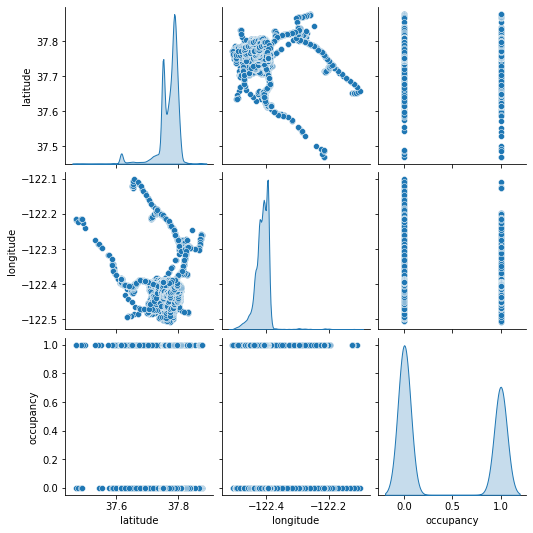

In [15]:
# latitude and longitude seem to have some outliers that then inpact all the analysis
feature_relations(cab_data.drop(columns = ['time', 'cab_id']))

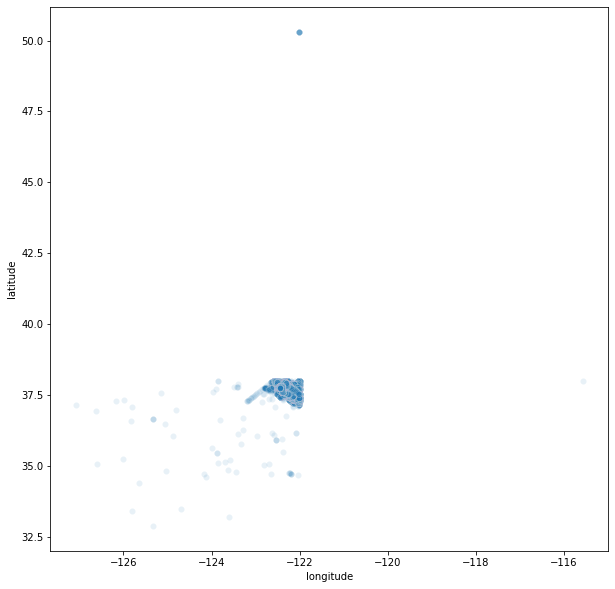

In [13]:
# lets evaluate the complete the positional distribution
# as expected, there are really some outliers that have to be dealt with
# for example the geolocation 50, -122 is in Canada
mobility_map(cab_data)

In [14]:
# same conclusion, alot of outliers
cab_data.describe()

,latitude,longitude,occupancy,time
count,1.122006e+07,1.122006e+07,1.122006e+07,1.122006e+07
mean,3.776360e+01,-1.224124e+02,4.472238e-01,1.212036e+09
std,5.385999e-02,3.578201e-02,4.972069e-01,5.885683e+05
min,3.286970e+01,-1.270814e+02,0.000000e+00,1.211018e+09
25%,3.775513e+01,-1.224253e+02,0.000000e+00,1.211523e+09
50%,3.778106e+01,-1.224111e+02,0.000000e+00,1.212043e+09
75%,3.779045e+01,-1.224003e+02,1.000000e+00,1.212549e+09
max,5.030546e+01,-1.155622e+02,1.000000e+00,1.213090e+09


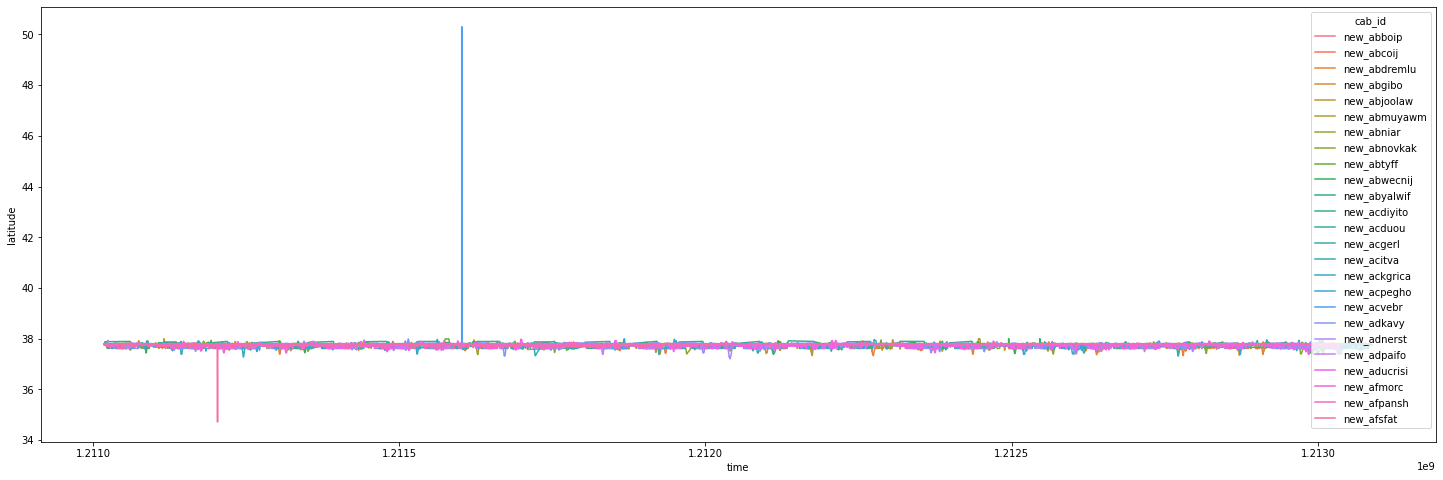

In [15]:
# lets explore the variation of latitude over the time to a sample data
# these outliers seem to be a lost of geolocation point at certain times of the day
feature_over_time(cab_data[:500000], y_variable='latitude')

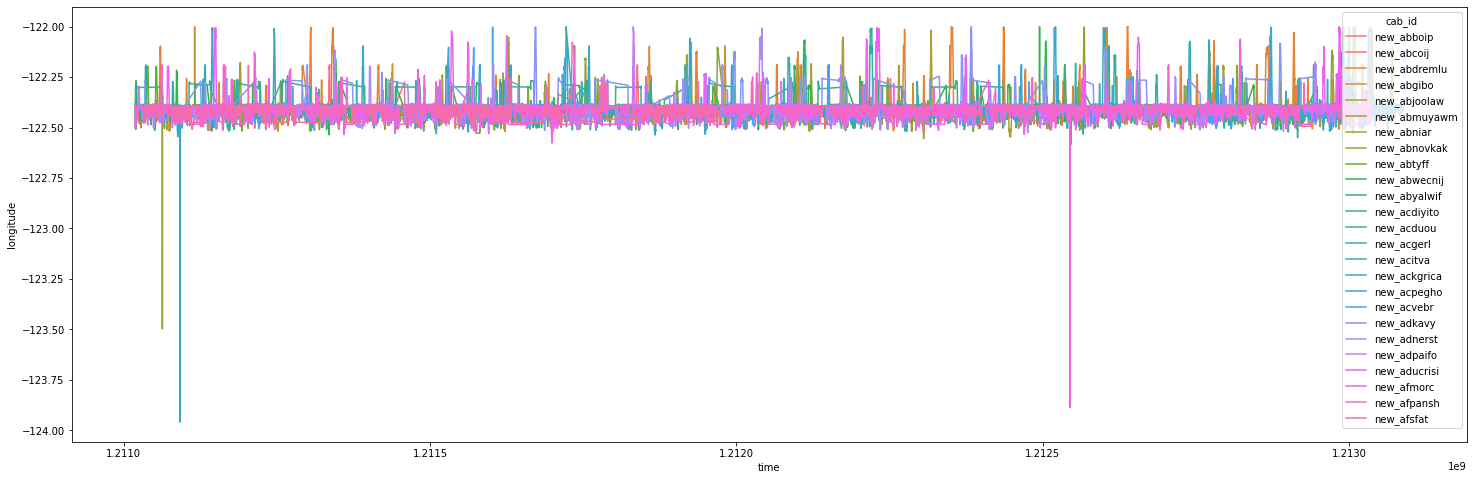

In [16]:
# the same happens to the longitude
feature_over_time(cab_data[:500000], y_variable='longitude')

#### Add features - distance, hours and velocity

Those outliers need to be evaluated and remove, but first lets add some features

In [17]:
# gets the aggregated cab data
file_name = '../data/01_raw/complete_cab_data.parquet'
cab_data = pd.read_parquet(file_name)

In [18]:
# prepares the cab data for the next steps
prepared_cab_data = prepare_data(cab_data)
prepared_cab_data.head()

2021-01-24 00:23:21,653 - INFO - wrapper - _convert_unix_epoch_to_date took 0:00:00.551037 shape=(11220058, 5) null_values=0)
2021-01-24 00:23:27,699 - INFO - wrapper - _sort_data took 0:00:05.660070 shape=(11220058, 5) null_values=0)
2021-01-24 00:45:56,231 - INFO - wrapper - _add_distances took 0:22:28.047090 shape=(11220058, 6) null_values=0)
2021-01-24 00:48:58,902 - INFO - wrapper - _add_hours took 0:03:02.245852 shape=(11220058, 7) null_values=0)
2021-01-24 00:49:00,677 - INFO - wrapper - _add_velocities took 0:00:01.261990 shape=(11220058, 8) null_values=0)
2021-01-24 00:49:51,123 - INFO - wrapper - _label_velocity_outliers took 0:00:49.896617 shape=(11220058, 9) null_values=0)


,latitude,longitude,occupancy,time,cab_id,distance,hour,velocity,outlier
0,37.75153,-122.39447,0,2008-05-17 14:12:10,new_abboip,0.000000,0.000000,0.000000,1
1,37.75149,-122.39447,0,2008-05-17 14:13:34,new_abboip,0.002759,0.023333,0.118229,1
2,37.75149,-122.39447,0,2008-05-17 14:14:34,new_abboip,0.000000,0.016667,0.000000,1
3,37.75149,-122.39446,0,2008-05-17 14:15:35,new_abboip,0.000548,0.016944,0.032318,1
4,37.75144,-122.39449,0,2008-05-17 14:41:43,new_abboip,0.003820,0.435556,0.008770,1


In [19]:
# saves the prepared cab data
file_name = '../data/02_intermediate/prepared_cab_data.parquet'
prepared_cab_data.to_parquet(file_name)

#### Evaluate  the new features

In [22]:
# reads prepared cab data
file_name = '../data/02_intermediate/prepared_cab_data.parquet'
prepared_cab_data = pd.read_parquet(file_name)

In [21]:
# distance is also heavily right skewed
# this makes sense since there are a lot of outliers
prepared_cab_data['distance'].describe()

count    1.122006e+07
mean     2.560358e-01
std      1.404568e+00
min      0.000000e+00
25%      2.013782e-02
50%      1.452212e-01
75%      2.860553e-01
max      8.764583e+02
Name: distance, dtype: float64

In [22]:
# hours between points presents some large numbers
# for example the max value is 400 hours... 
prepared_cab_data['hour'].describe()

count    1.122006e+07
mean     2.532151e-02
std      4.352977e-01
min      0.000000e+00
25%      1.444444e-02
50%      1.666667e-02
75%      1.722222e-02
max      4.135228e+02
Name: hour, dtype: float64

<AxesSubplot:xlabel='time'>

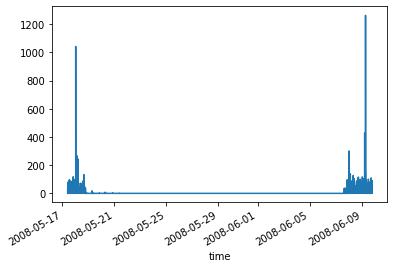

In [23]:
# lets see what is happening
# it seems that the cab driver just didn't work for a whole 400 hours
prepared_cab_data.query('cab_id == "new_ayshowg"').set_index('time')['velocity'].plot()

In [25]:
# has expected there are some large numbers of velocity
# this is most likelly due to the outliers (the max value is above the speed of sound!)
prepared_cab_data['velocity'].describe()

count    1.122006e+07
mean     2.180528e+01
std      7.701564e+02
min      0.000000e+00
25%      1.748732e+00
50%      9.137156e+00
75%      1.716054e+01
max      1.554486e+06
Name: velocity, dtype: float64

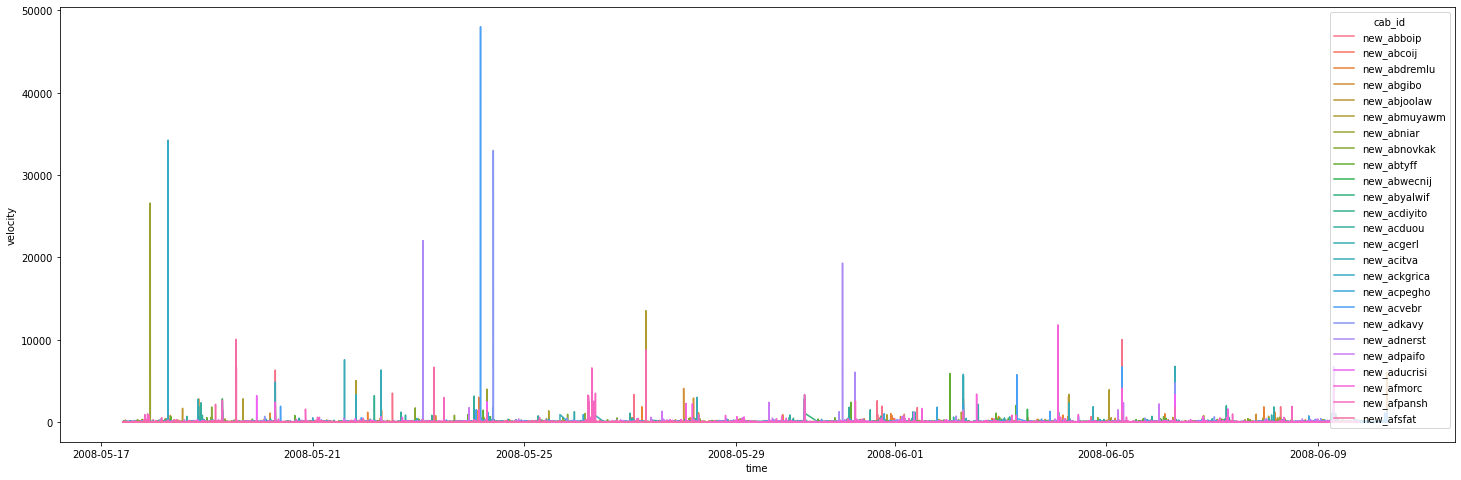

In [26]:
# has expected there are some spikes in the velocity
feature_over_time(prepared_cab_data[:500000], y_variable='velocity')

#### Outlier removal

The data presents a large quantity of outliers and bad measurments. Let's try some techniques in removing them.

##### Isolation forest method

In [27]:
# Isolation Forest
# I'll use a contamination of 1% (percentage of data to be removed)
from sklearn.ensemble import IsolationForest

outlier_input_data = prepared_cab_data[['latitude', 'longitude', 'velocity']]
contamination = 0.01

clf = IsolationForest(n_estimators=20, contamination=contamination, random_state=0, n_jobs=-1)
pred = clf.fit_predict(outlier_input_data)

In [28]:
# output preparation
prepared_cab_data_if_out = prepared_cab_data.copy()
prepared_cab_data_if_out.loc[:, 'outlier'] = pred

In [29]:
# as expected the % is equal to the contamination factor
outliers = len(prepared_cab_data_if_out.query('outlier == -1'))
total = len(prepared_cab_data_if_out)
print(f'Isolation Forest method removed {round(outliers/total * 100,2)} % of the data')

Isolation Forest method removed 1.0 % of the data


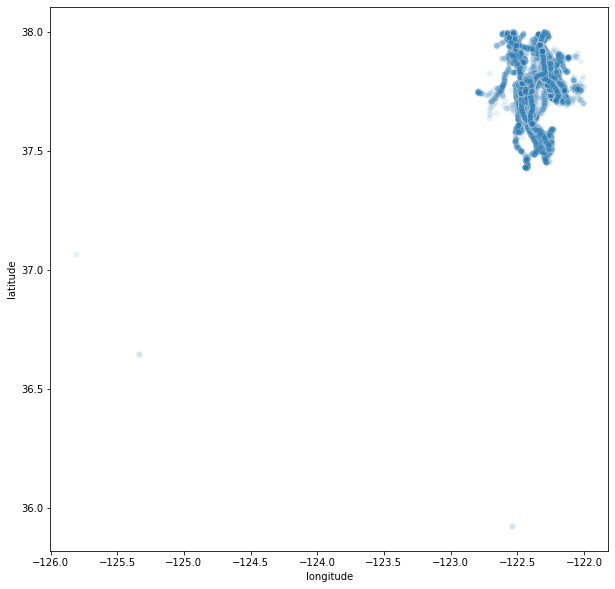

In [30]:
# still have some points that weren't removed
mobility_map(prepared_cab_data_if_out.query('outlier == 1'))

In [31]:
# but the were only 5
len(prepared_cab_data_if_out.query('outlier == 1').query('latitude < 37.2'))

5

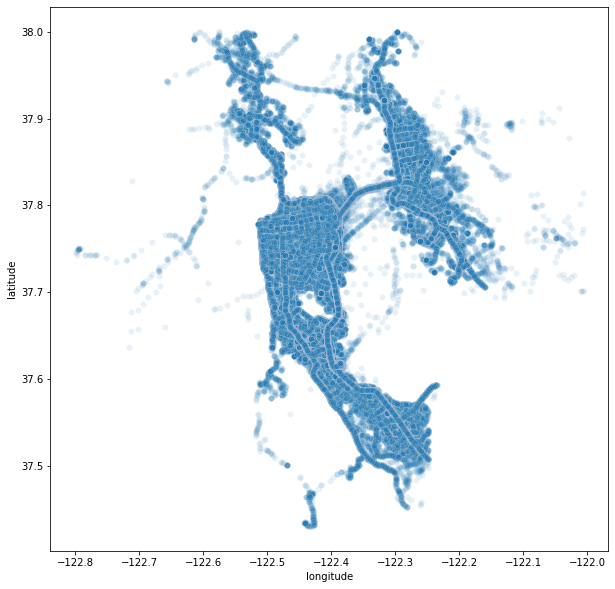

In [32]:
# after removing the extra 5 points I can see san francisco better
# however, I'm losing a lot of information from the south of the town, especially the bridges part
mobility_map(prepared_cab_data_if_out.query('outlier == 1').query('latitude > 37.2'))

In [33]:
# save final data
final_data_if_method = prepared_cab_data_if_out.query('outlier == 1')
file_name = '../data/03_processed/cab_data_wo_outliers_if_method.parquet'
final_data_if_method.to_parquet(file_name)

##### Local Outlier Factor

In [34]:
# Local Outlier Factor
# I'll use a contamination of 1% (percentage of data to be removed)
from sklearn.neighbors import LocalOutlierFactor

outlier_input_data = prepared_cab_data[['latitude', 'longitude', 'velocity']]
contamination = 0.01

clf = LocalOutlierFactor(contamination=contamination, n_jobs=-1)
pred = clf.fit_predict(outlier_input_data)

In [35]:
# output preparation
prepared_cab_data_lof_out = prepared_cab_data.copy()
prepared_cab_data_lof_out.loc[:, 'outlier'] = pred

In [36]:
# as expected the % is equal to the contamination factor
outliers = len(prepared_cab_data_lof_out.query('outlier == -1'))
total = len(prepared_cab_data_lof_out)
print(f'Velocity method removed {round(outliers/total * 100,2)} % of the data')

Velocity method removed 1.0 % of the data


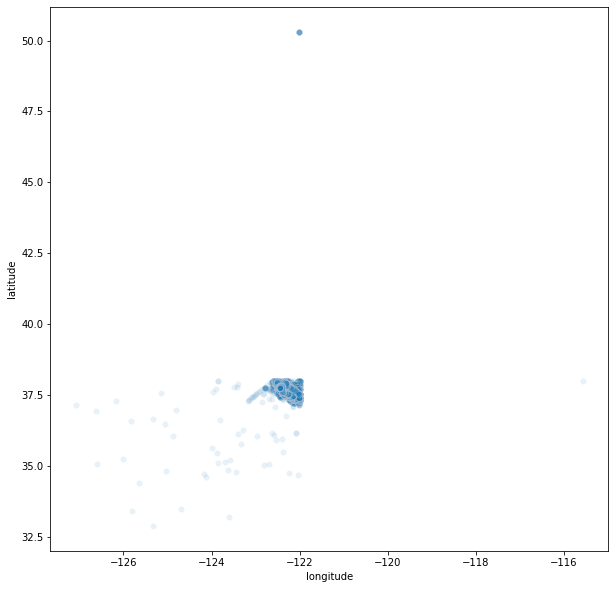

In [37]:
# there are still a lot of point that are outliers when you look at the map, so it's not a good option
mobility_map(prepared_cab_data_lof_out.query('outlier == 1'))

In [38]:
# save final data
final_data_lof_method = prepared_cab_data_lof_out.query('outlier == 1')
file_name = '../data/03_processed/cab_data_wo_outliers_lof_method.parquet'
final_data_lof_method.to_parquet(file_name)

##### Minimum Covariance Determinant

In [39]:
# Minimum Covariance Determinant
# I'll use a contamination of 1% (percentage of data to be removed)
from sklearn.covariance import EllipticEnvelope

outlier_input_data = prepared_cab_data[['latitude', 'longitude', 'velocity']]
contamination = 0.01

clf = EllipticEnvelope(contamination=0.01, random_state = 0)
pred = clf.fit_predict(outlier_input_data)

In [40]:
# output preparation
prepared_cab_data_mcd_out = prepared_cab_data.copy()
prepared_cab_data_mcd_out.loc[:, 'outlier'] = pred

In [41]:
# as expected the % is equal to the contamination factor
outliers = len(prepared_cab_data_mcd_out.query('outlier == -1'))
total = len(prepared_cab_data_mcd_out)
print(f'Velocity method removed {round(outliers/total * 100,2)} % of the data')

Velocity method removed 1.0 % of the data


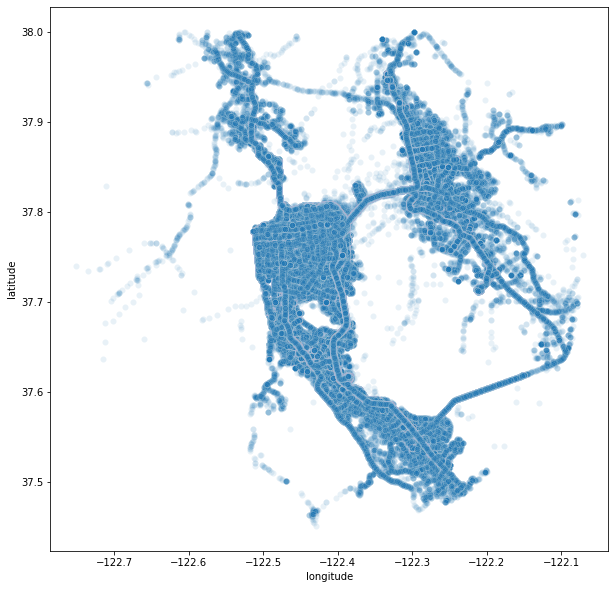

In [42]:
# so far this is the best option keeping not only the bridges but also removing all of the big outliers
# however, there is still are a lot of points removed at the south
mobility_map(prepared_cab_data_mcd_out.query('outlier == 1'))

In [43]:
# save final data
final_data_mcd_method = prepared_cab_data_mcd_out.query('outlier == 1')
file_name = '../data/03_processed/cab_data_wo_outliers_mcd_method.parquet'
final_data_lof_method.to_parquet(file_name)

##### Velocity method

In [44]:
# this method basically uses the calculated point velocity to evaluate if the measurement is bad or not
# if for some reason the gps registers a bad location the velocity will present a big spike
# i assume a velocity threshold of 85 mph (maximum velocity in the US)
prepared_cab_data_velocity_out = _label_velocity_outliers(prepared_cab_data, 85)

2021-01-24 01:44:24,232 - INFO - wrapper - _label_velocity_outliers took 0:00:47.093797 shape=(11220058, 9) null_values=0)


In [45]:
# evaluation of % of outliers removed
outliers = len(prepared_cab_data_velocity_out.query('outlier == -1'))
total = len(prepared_cab_data)
print(f'Velocity method removed {round(outliers/total * 100, 2)} % of the data')

Velocity method removed 1.19 % of the data


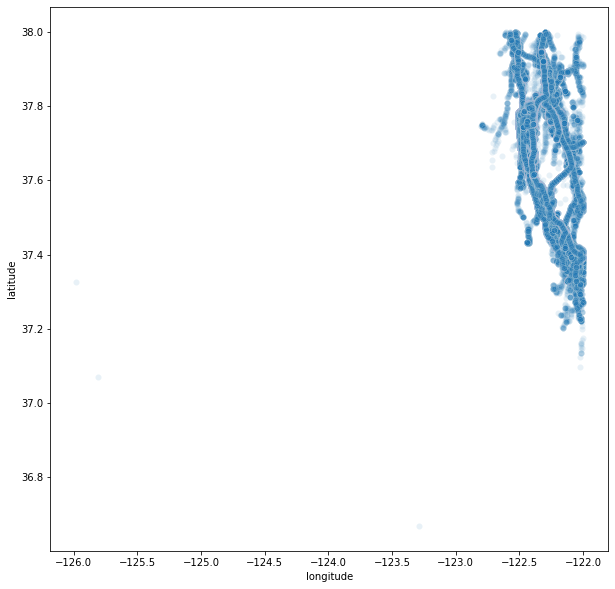

In [46]:
# still have some points that weren't removed (respected the velocity limit)
mobility_map(prepared_cab_data_velocity_out.query('outlier == 1'))

In [47]:
# but they are only 3 points
prepared_cab_data_velocity_out.query('outlier == 1').query('longitude < -123')

,latitude,longitude,occupancy,time,cab_id,distance,hour,velocity,outlier
6806,36.66794,-123.28627,1,2008-05-23 21:38:33,new_arlwras,81.848375,1.410278,58.037059,1
10083,37.32506,-125.98423,0,2008-06-02 11:29:43,new_eemafbij,195.212682,2.975833,65.599333,1
19080,37.06908,-125.81021,0,2008-06-04 12:39:42,new_upsjavci,192.310018,4.183333,45.970522,1


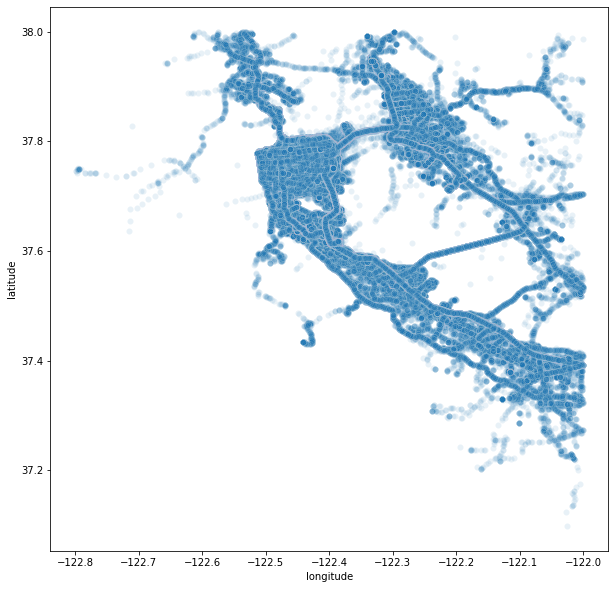

In [48]:
# after removing this last 3 point the graph seems quite good
# I only removed 1.2% of the data still have all the zones of san francisco with data points
mobility_map(prepared_cab_data_velocity_out.query('outlier == 1').query('longitude > -123'))

In [49]:
# save final data
final_data_velocity_method = prepared_cab_data_velocity_out.query('outlier == 1').query('longitude > -123')
prepared_final_data_velocity_method = prepare_data(final_data_velocity_method)
file_name = '../data/03_processed/cab_data_wo_outliers_velocity_method.parquet'
prepared_final_data_velocity_method.to_parquet(file_name)

2021-01-24 01:44:58,709 - INFO - wrapper - _convert_unix_epoch_to_date took 0:00:00.401692 shape=(11086377, 9) null_values=0)
2021-01-24 01:45:04,723 - INFO - wrapper - _sort_data took 0:00:05.546971 shape=(11086377, 9) null_values=0)
2021-01-24 02:06:14,289 - INFO - wrapper - _add_distances took 0:21:09.017530 shape=(11086377, 9) null_values=0)
2021-01-24 02:09:07,787 - INFO - wrapper - _add_hours took 0:02:53.042682 shape=(11086377, 9) null_values=0)
2021-01-24 02:09:09,210 - INFO - wrapper - _add_velocities took 0:00:00.881024 shape=(11086377, 9) null_values=0)
2021-01-24 02:09:35,716 - INFO - wrapper - _label_velocity_outliers took 0:00:25.967401 shape=(11086377, 9) null_values=0)
